In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from plotnine import *

from py_helper_functions import *

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

from stargazer import stargazer

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment1/morg-2014-emp.csv')
df.head()

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent
2,6,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,...,2,6,"Native, Born In US",63,Motor vehicles and motor vehicle equipment man...,8140,"Private, For Profit",No,No,Employed-At Work
3,10,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,...,2,4,"Native, Born In US",63,"**Publishing, except newspapers and software (...",8255,"Private, For Profit",Yes,NaN,Employed-At Work
4,11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,...,2,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work


In [3]:
# Filter the data for occ2012 between 7700 and 8965, work week > 0, work minimum 20hrs per week and hourly wage >= 1
comp_sample = df[(df['occ2012'] >= 1005)
                & (df['occ2012'] <= 1107)
                & (df['uhours'] >= 20) 
                & (df['earnwke'] > 0)
                & (df['earnwke']/df['uhours'] >= 1)].iloc[:, 1:]

#drop the raw df
del df

In [4]:
# Add a column 'hourly_wage' to the DataFrame
comp_sample['hourly_wage'] = (comp_sample['earnwke'] / comp_sample['uhours']).round(decimals=2)
# Add the natural log of wage (ln_wage) column
comp_sample['ln_wage'] = np.log(comp_sample['hourly_wage']).round(decimals=2)
# add column female to have boolean for male or female
comp_sample['female'] = comp_sample['sex'].apply(lambda x: 1 if x == 2 else 0)
# create dummy variables for Bachelor degree holders and Post Graduate degree holders
comp_sample['ed_BA'] = (comp_sample["grade92"] == 43).astype(int)
comp_sample['ed_PostGrad'] = (comp_sample["grade92"] >= 44).astype(int)
# add column for age squared
comp_sample['agesq'] = np.power(comp_sample['age'], 2)
# add column for citizen to have boolean value if worker has US citizenship
comp_sample['citizen'] = comp_sample['prcitshp'].apply(lambda x: 0 if 'Not' in x else 1)
# round to 2 decimal places
comp_sample = comp_sample.round(decimals=2)

In [5]:
# check the comp_sample data
comp_sample.head()

,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,age,...,unionmme,unioncov,lfsr94,hourly_wage,ln_wage,female,ed_BA,ed_PostGrad,agesq,citizen
16,731019430119001,January,AL,2992.10,1538.46,40,43,2,NaN,53,...,No,No,Employed-At Work,38.46,3.65,1,1,0,2809,1
155,673032906039520,January,AK,411.56,1346.15,40,39,3,NaN,47,...,No,No,Employed-At Work,33.65,3.52,1,0,0,2209,1
293,207004430306994,January,AZ,3410.89,2500.00,40,44,4,NaN,51,...,No,No,Employed-At Work,62.50,4.14,0,0,1,2601,1
296,236096309400800,January,AZ,3916.33,2500.00,40,43,4,NaN,47,...,No,No,Employed-At Work,62.50,4.14,0,1,0,2209,1
324,914299270769003,January,AZ,5115.47,1250.00,45,43,1,NaN,37,...,No,No,Employed-At Work,27.78,3.32,0,1,0,1369,1


In [6]:
# get the comp_sample summary statistics
comp_stats = comp_sample[['earnwke', 'uhours', 'hourly_wage', 'ln_wage']].describe().T
comp_stats['mode'] = comp_sample[['earnwke', 'uhours', 'hourly_wage', 'ln_wage']].mode().squeeze()
comp_stats.T

,earnwke,uhours,hourly_wage,ln_wage
count,4326.000000,4326.000000,4326.000000,4326.000000
mean,1433.989760,41.486362,34.507612,3.427785
std,668.489938,5.659811,15.660631,0.499927
min,92.300000,20.000000,2.310000,0.840000
25%,920.000000,40.000000,22.235000,3.100000
50%,1346.150000,40.000000,32.200000,3.470000
75%,1923.000000,40.000000,45.000000,3.810000
max,2884.610000,80.000000,120.190000,4.790000
mode,2884.610000,40.000000,48.080000,3.870000


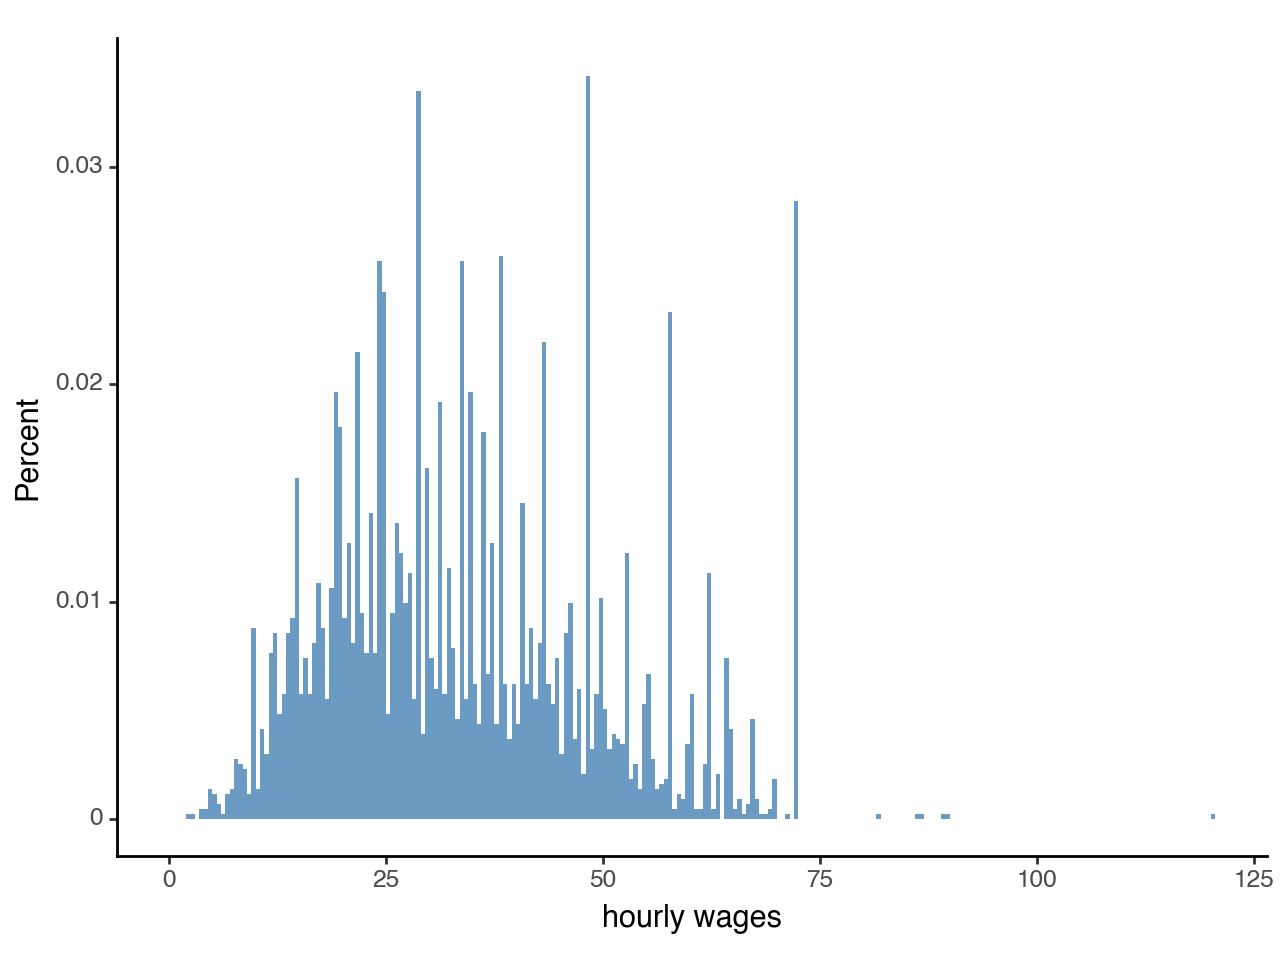

<Figure Size: (640 x 480)>

In [7]:
# hourly_wage distribution
(
    ggplot(comp_sample, aes(x="hourly_wage", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=0.5,
        boundary=0,
        size=0.25,
        alpha=0.8,
        show_legend=True,
        na_rm=True,
        fill='steelblue'
    )
    + labs(x="hourly wages", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + theme_classic()
)

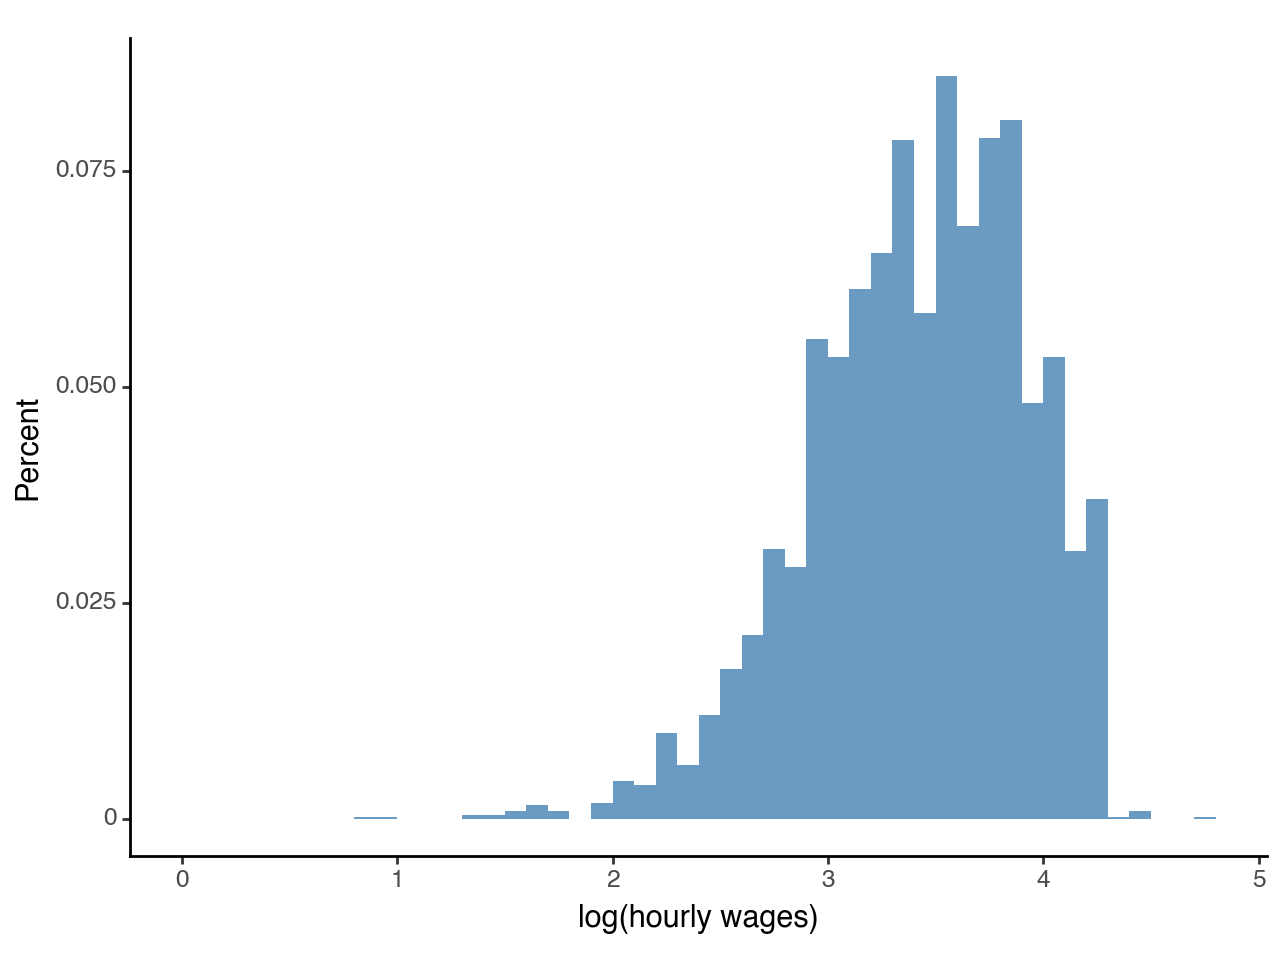

<Figure Size: (640 x 480)>

In [8]:
# ln(hourly_wage) distribution
(
    ggplot(comp_sample, aes(x="ln_wage", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=0.1,
        boundary=0,
        size=0.25,
        alpha=0.8,
        show_legend=True,
        na_rm=True,
        fill='steelblue'
    )
    + labs(x="log(hourly wages)", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + theme_classic()
)

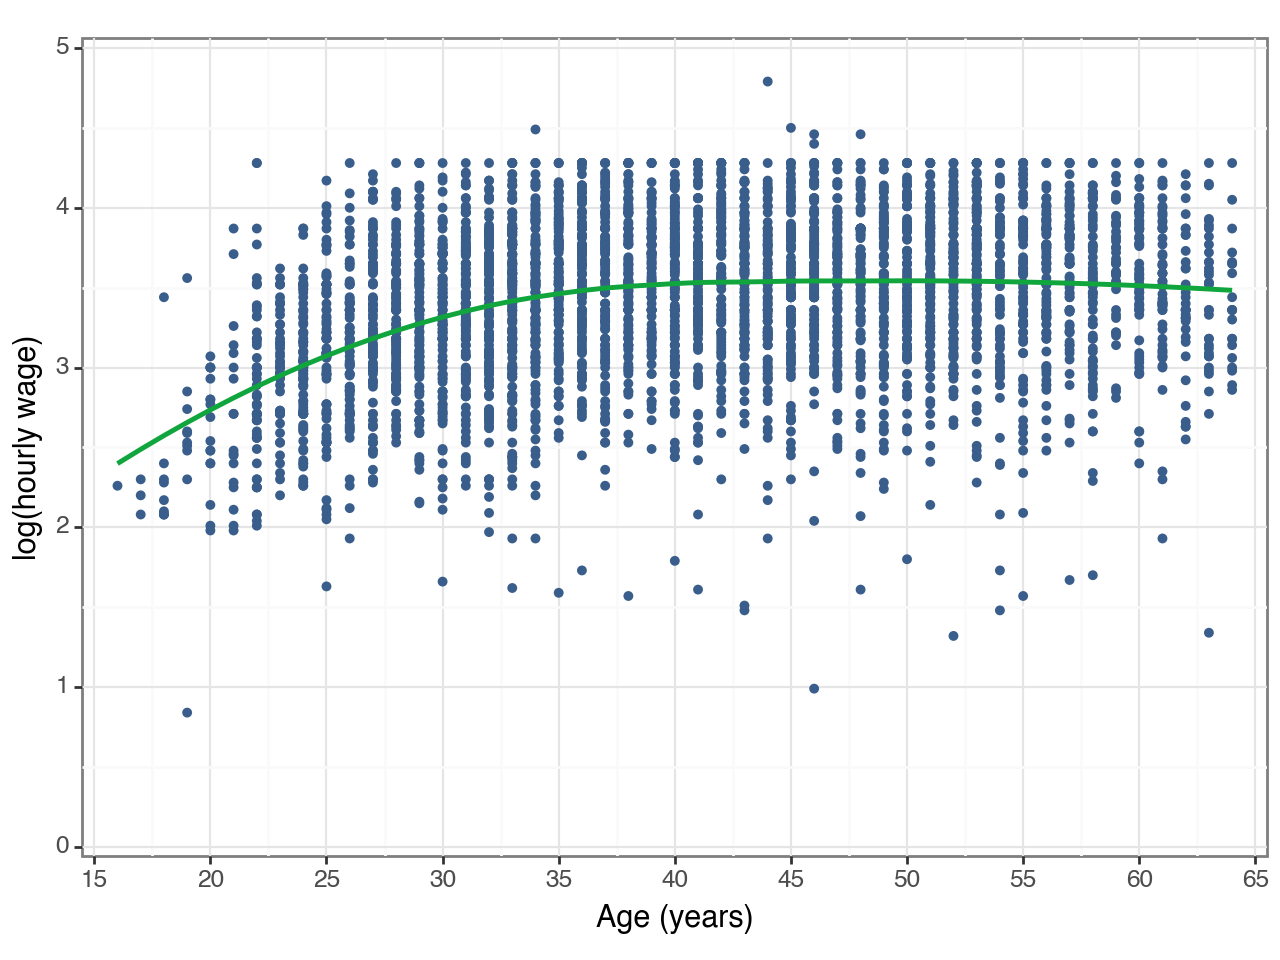

<Figure Size: (640 x 480)>

In [9]:
# lowess
(ggplot(comp_sample, aes(x="age", y="ln_wage")) 
 + geom_point(color=color[0], size=1, alpha=0.8, show_legend=False, na_rm=True) 
 + geom_smooth(method="loess", se=False, colour=color[1], size=1, span=0.9) 
 + labs(
    x="Age (years)", y="log(hourly wage)") 
 + theme_bw() 
 + expand_limits(x=0.01, y=0.01)
 + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 5), breaks=seq(0, 5, 1))
 + scale_x_continuous(expand=(0.01, 0.01), limits=(15, 65), breaks=seq(0, 65, 5))
 )

In [10]:
comp_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4326 entries, 16 to 149221
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hhid         4326 non-null   int64  
 1   intmonth     4326 non-null   object 
 2   stfips       4326 non-null   object 
 3   weight       4326 non-null   float64
 4   earnwke      4326 non-null   float64
 5   uhours       4326 non-null   int64  
 6   grade92      4326 non-null   int64  
 7   race         4326 non-null   int64  
 8   ethnic       222 non-null    float64
 9   age          4326 non-null   int64  
 10  sex          4326 non-null   int64  
 11  marital      4326 non-null   int64  
 12  ownchild     4326 non-null   int64  
 13  chldpres     4326 non-null   int64  
 14  prcitshp     4326 non-null   object 
 15  state        4326 non-null   object 
 16  ind02        4326 non-null   object 
 17  occ2012      4326 non-null   int64  
 18  class        4326 non-null   object 
 19  unionmme

In [11]:
# create the regression models
reg1 = smf.ols(formula="ln_wage ~ age + agesq", data=comp_sample).fit(cov_type="HC1")
reg2 = smf.ols(formula="ln_wage ~ age + agesq + citizen", data=comp_sample).fit(cov_type="HC1")
reg3 = smf.ols(formula="ln_wage ~ age + agesq + citizen + female + ownchild", data=comp_sample).fit(cov_type="HC1")
reg4 = smf.ols(formula="ln_wage ~ age + agesq + citizen + female + ownchild + ed_BA + ed_PostGrad", data=comp_sample).fit(cov_type="HC1")

reg_list = [reg1, reg2, reg3, reg4]
bic = [round(x.bic, 2) for x in reg_list]
sg = stargazer.Stargazer(reg_list)
sg.add_line('BIC', bic, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg